# Librairies

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.grid_search import GridSearchCV

# algorithmes utilisés :
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier 
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

C:\Users\Paul\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\Paul\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
C:\Users\Paul\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


# Lecture du dataset

In [2]:
col = ["height","lenght","area","eccen","p_black","p_and","mean_tr","blackpix","blackand","wb_trans","classes"]
df = pd.read_csv("page-blocks.csv", sep=';',header=None, names=col,index_col=False)

# Split du dataset

Séparons de manière aléatoire le dataset en un train set et un test set (80% - 20%) qui nous permettront d'éviter l'overfitting.

In [3]:
x_train, x_test, y_train, y_test = train_test_split(df.loc[:, df.columns !="classes"], df["classes"], test_size=0.2, random_state = 7)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(4378, 10) (4378,)
(1095, 10) (1095,)


# Modelisation

Le contexte de notre modélisation est une classification avec 5 classes possibles (text, horizontal line, vertical line, graphic, picture). Pour trouver le modèle avec les meilleurs résultats, plusieurs modèles préseléctionnés vont être testés avec des paramètres non-optimisés puis ces modèles seront comparés.

### Comparaison des modèles

In [4]:
models = []
models.append(('LR', LogisticRegression()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('RF', RandomForestClassifier()))
models.append(('ET', ExtraTreesClassifier()))
models.append(('MNB', MultinomialNB()))
models.append(('BNB', BernoulliNB()))
models.append(('MLP', MLPClassifier()))
models.append(('GB', GradientBoostingClassifier()))

In [5]:
results = []
names = []
results_mean =  []
scoring = 'accuracy'
seed = 7
for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=seed)
    cv_results = model_selection.cross_val_score(model, x_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    results_mean.append(cv_results.mean())
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.956830 (0.007942)
KNN: 0.955917 (0.009245)
CART: 0.961398 (0.009281)
RF: 0.971220 (0.007095)
ET: 0.969164 (0.006316)
MNB: 0.915714 (0.013100)
BNB: 0.898816 (0.014135)
MLP: 0.948841 (0.018987)
GB: 0.972590 (0.004087)


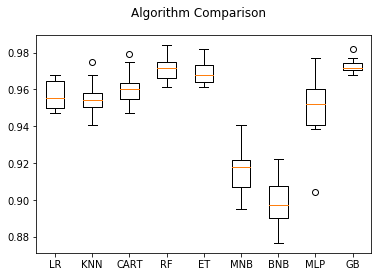

In [6]:
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

Nous pouvons voir grâce au graphique précédent que les modèles de Naive Bayes (Bernouilli et multinomial) ne font pas ou peu mieux que les 89% évoqués dans l'exploration des données. 

In [7]:
results_mean = pd.DataFrame(results_mean)
results_mean['name'] = names
results_mean.columns = ['score', 'name']
results_mean=results_mean.sort_values('score', ascending=False)
results_mean.drop(results_mean.tail(2).index,inplace=True)

(0.94, 1)

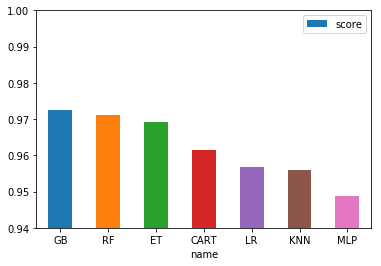

In [8]:
ax = results_mean.plot.bar(x='name', y='score', rot=0)
ax.set_ylim(ymin=0.94,ymax=1)

Nous remarquons que le modèle avec le meilleur score est le Gradient Boosting. Il faut maintenant trouver les meilleurs paramètres pour maximiser les prédictions correctes.

### Optimisation des hyperparamètres

Tout d'abord, testons le modèle non-optimisé sur le jeu de test.

In [9]:
model_GB = GradientBoostingClassifier().fit(x_train, y_train)
y_pred = model_GB.predict(x_test)
from sklearn import metrics
print("Gradient Boosting accuracy :", metrics.accuracy_score(y_test, y_pred))

Gradient Boosting accuracy : 0.9753424657534246


In [10]:
depths = {'max_depth':[2,3,4,5,6,7] }
tuning = GridSearchCV(estimator =GradientBoostingClassifier(learning_rate=0.01,n_estimators=1500, min_samples_split=2, min_samples_leaf=1, subsample=1,max_features='sqrt', random_state=10), 
            param_grid = depths, scoring='accuracy',n_jobs=4,iid=False, cv=5)
tuning.fit(x_train,y_train)
tuning.grid_scores_, tuning.best_params_, tuning.best_score_

([mean: 0.97305, std: 0.00293, params: {'max_depth': 2},
  mean: 0.97396, std: 0.00299, params: {'max_depth': 3},
  mean: 0.97328, std: 0.00309, params: {'max_depth': 4},
  mean: 0.97282, std: 0.00263, params: {'max_depth': 5},
  mean: 0.97191, std: 0.00325, params: {'max_depth': 6},
  mean: 0.97236, std: 0.00219, params: {'max_depth': 7}],
 {'max_depth': 3},
 0.973963181385483)

In [11]:
samples_split_leaf = {'min_samples_split':[2,4,6,8,10,20,40,60,100], 'min_samples_leaf':[1,3,5,7,9]}

tuning = GridSearchCV(estimator =GradientBoostingClassifier(learning_rate=0.01, n_estimators=1500,max_depth=3, subsample=1,max_features='sqrt', random_state=10), 
            param_grid = samples_split_leaf, scoring='accuracy',n_jobs=4,iid=False, cv=5)
tuning.fit(x_train,y_train)
tuning.grid_scores_, tuning.best_params_, tuning.best_score_

([mean: 0.97396, std: 0.00299, params: {'min_samples_leaf': 1, 'min_samples_split': 2},
  mean: 0.97374, std: 0.00320, params: {'min_samples_leaf': 1, 'min_samples_split': 4},
  mean: 0.97396, std: 0.00315, params: {'min_samples_leaf': 1, 'min_samples_split': 6},
  mean: 0.97351, std: 0.00281, params: {'min_samples_leaf': 1, 'min_samples_split': 8},
  mean: 0.97351, std: 0.00299, params: {'min_samples_leaf': 1, 'min_samples_split': 10},
  mean: 0.97328, std: 0.00283, params: {'min_samples_leaf': 1, 'min_samples_split': 20},
  mean: 0.97328, std: 0.00254, params: {'min_samples_leaf': 1, 'min_samples_split': 40},
  mean: 0.97305, std: 0.00341, params: {'min_samples_leaf': 1, 'min_samples_split': 60},
  mean: 0.97282, std: 0.00316, params: {'min_samples_leaf': 1, 'min_samples_split': 100},
  mean: 0.97351, std: 0.00251, params: {'min_samples_leaf': 3, 'min_samples_split': 2},
  mean: 0.97351, std: 0.00251, params: {'min_samples_leaf': 3, 'min_samples_split': 4},
  mean: 0.97351, std: 0.00

In [12]:
max_features = {'max_features':[2,3,4,5,6,7]}
tuning = GridSearchCV(estimator =GradientBoostingClassifier(learning_rate=0.01, n_estimators=1500,max_depth=3, min_samples_split=6, min_samples_leaf=1, subsample=1, random_state=10), 
param_grid = max_features, scoring='accuracy',n_jobs=4,iid=False, cv=5)
tuning.fit(x_train,y_train)
tuning.grid_scores_, tuning.best_params_, tuning.best_score_

([mean: 0.97305, std: 0.00244, params: {'max_features': 2},
  mean: 0.97396, std: 0.00315, params: {'max_features': 3},
  mean: 0.97396, std: 0.00262, params: {'max_features': 4},
  mean: 0.97282, std: 0.00375, params: {'max_features': 5},
  mean: 0.97259, std: 0.00424, params: {'max_features': 6},
  mean: 0.97237, std: 0.00346, params: {'max_features': 7}],
 {'max_features': 3},
 0.9739637026430168)

In [13]:
model_GB = GradientBoostingClassifier(learning_rate=0.01, n_estimators=1500,max_depth=3, min_samples_split=6, min_samples_leaf=1, subsample=1, random_state=10, max_features = 3).fit(x_train, y_train)
y_pred = model_GB.predict(x_test)
from sklearn import metrics
print("Gradient Boosting accuracy :", metrics.accuracy_score(y_test, y_pred))

Gradient Boosting accuracy : 0.9771689497716894


La précision des prédictions est de 97.7%, le modèle explique avec une bonne précision la classe d'un élément d'une page par rapport aux observation. Ce test étant fait sur un dataset sur lequel le modèle n'a pas été entraîné, cela signifie que l'algorithme ne fait pas de suraprentissage.

L'optimistation des hyperparamètres a permis d'augmenter très légèrement la justesse des prédictions, de manière peu significative (97.3 % à 97.7 %).